# Track Linearization Tutorial

This notebook demonstrates how to convert 2D spatial trajectories into 1D linear positions using the `track_linearization` package.

**What you'll learn:**
1. Creating simple track structures (linear, circular)
2. Linearizing 2D positions onto tracks
3. Working with complex tracks (W-track)
4. Using edge mapping to merge track segments
5. Handling noisy data with HMM inference

**Prerequisites:** Basic Python and NumPy knowledge. Familiarity with spatial tracking data is helpful but not required.

## Setup

First, let's import the necessary libraries and configure the notebook for interactive plotting.

In [1]:
# Auto-reload modules during development (optional)
%load_ext autoreload
%autoreload 2

# Enable interactive matplotlib plots
%matplotlib inline

In [2]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Track linearization functions
from track_linearization import (
    make_track_graph,
    get_linearized_position,
    plot_track_graph,
)
from track_linearization.utils import plot_graph_as_1D

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All imports successful!")

✓ All imports successful!


---
## Example 1: Simple Linear Track

Let's start with the simplest case: a straight track from point A to point B.

### Concept
We'll create a track with 2 nodes and 1 edge, then linearize some positions along it.

In [3]:
# Define a simple linear track: 100 cm horizontal line
node_positions = [
    (0, 0),    # Node 0: start point
    (100, 0),  # Node 1: end point
]

edges = [
    (0, 1),    # Edge connecting node 0 to node 1
]

# Create the track graph
linear_track = make_track_graph(node_positions, edges)

print(f"Track created with {linear_track.number_of_nodes()} nodes and {linear_track.number_of_edges()} edges")
print(f"Track length: {linear_track.edges[0, 1]['distance']:.1f} cm")

Track created with 2 nodes and 1 edges
Track length: 100.0 cm


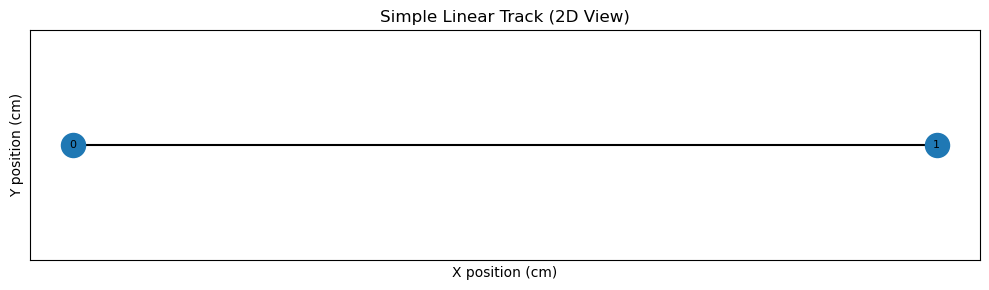

In [4]:
# Visualize the track structure
fig, ax = plt.subplots(figsize=(10, 3))
plot_track_graph(linear_track, ax=ax)
ax.set_title("Simple Linear Track (2D View)")
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
plt.tight_layout()
plt.show()

In [5]:
# Simulate animal positions along the track
# An animal moving from left to right
position = np.array([
    [10, 0],   # 10 cm from start
    [25, 0],   # 25 cm from start
    [50, 0],   # Midpoint
    [75, 0],   # 75 cm from start
    [90, 0],   # Near end
])

print(f"Tracking {len(position)} positions along the track")

Tracking 5 positions along the track


In [6]:
# Convert 2D positions to 1D linear positions
result = get_linearized_position(position, linear_track)

print("\n📊 Linearization Results:")
print("=" * 60)
print(result.to_string(index=False))
print("\n💡 Note: linear_position matches the X coordinate because the track is horizontal")


📊 Linearization Results:
 linear_position  track_segment_id  projected_x_position  projected_y_position
            10.0                 0                  10.0                   0.0
            25.0                 0                  25.0                   0.0
            50.0                 0                  50.0                   0.0
            75.0                 0                  75.0                   0.0
            90.0                 0                  90.0                   0.0

💡 Note: linear_position matches the X coordinate because the track is horizontal


### Understanding the Output

The `get_linearized_position()` function returns a DataFrame with:
- **`linear_position`**: The 1D position along the track (in the same units as your input)
- **`track_segment_id`**: Which edge the position is on (0 in this simple case)
- **`projected_x_position`**, **`projected_y_position`**: The closest point on the track to your input position

For a straight horizontal track, the linear position equals the X coordinate!

---
## Example 2: L-Shaped Track

Now let's try a more interesting shape: an L-shaped track with two connected segments.

### Concept
This demonstrates how linearization handles multiple edges and creates a continuous 1D coordinate system.

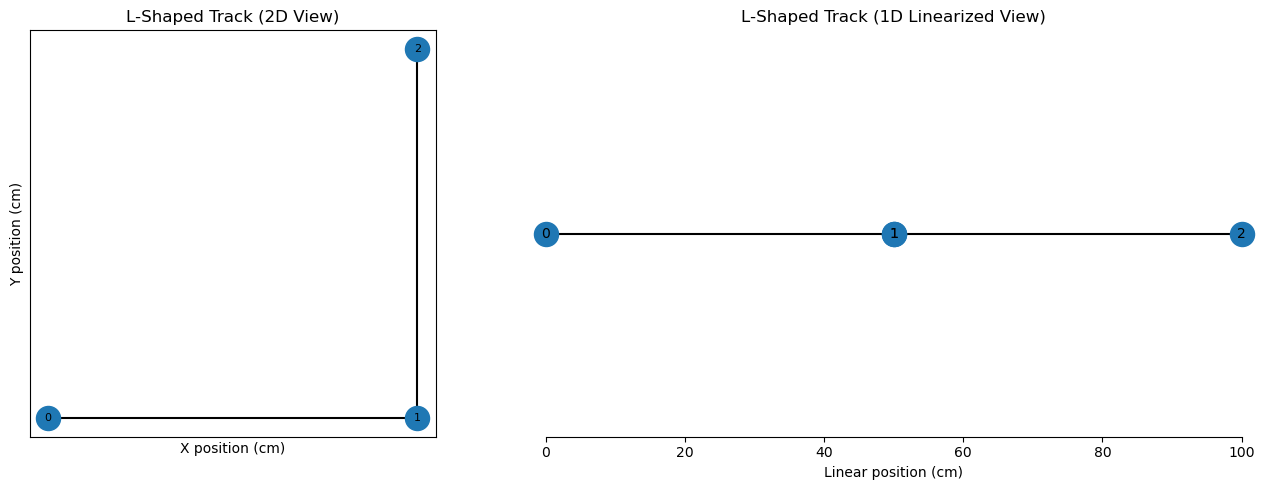

Total track length: 100.0 cm


In [7]:
# Define an L-shaped track
node_positions = [
    (0, 0),     # Node 0: bottom-left corner
    (50, 0),    # Node 1: corner (junction)
    (50, 50),   # Node 2: top of vertical segment
]

edges = [
    (0, 1),  # Horizontal segment (edge 0)
    (1, 2),  # Vertical segment (edge 1)
]

l_track = make_track_graph(node_positions, edges)

# Visualize the L-shaped track
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 2D view
plot_track_graph(l_track, ax=axes[0])
axes[0].set_title("L-Shaped Track (2D View)")
axes[0].set_xlabel("X position (cm)")
axes[0].set_ylabel("Y position (cm)")
axes[0].set_aspect('equal')

# 1D linearized view
plot_graph_as_1D(l_track, ax=axes[1])
axes[1].set_title("L-Shaped Track (1D Linearized View)")
axes[1].set_xlabel("Linear position (cm)")

plt.tight_layout()
plt.show()

print(f"Total track length: {sum(l_track.edges[e]['distance'] for e in l_track.edges()):.1f} cm")

In [8]:
# Simulate positions along both segments
position = np.array([
    [10, 0],    # On horizontal segment
    [40, 0],    # Near the corner (horizontal)
    [50, 10],   # Just around the corner (vertical)
    [50, 30],   # Middle of vertical segment
    [50, 45],   # Near top of vertical segment
])

result = get_linearized_position(position, l_track)

print("\n📊 Linearization Results for L-Track:")
print("=" * 60)
print(result.to_string(index=False))
print("\n💡 Notice how positions on segment 1 have linear_position > 50 cm")
print("   (continuing from where segment 0 ended)")


📊 Linearization Results for L-Track:
 linear_position  track_segment_id  projected_x_position  projected_y_position
            10.0                 0                  10.0                   0.0
            40.0                 0                  40.0                   0.0
            60.0                 1                  50.0                  10.0
            80.0                 1                  50.0                  30.0
            95.0                 1                  50.0                  45.0

💡 Notice how positions on segment 1 have linear_position > 50 cm
   (continuing from where segment 0 ended)


### Adding Edge Spacing

Sometimes you want a gap between segments in your linearized representation. This can help visually separate different track sections.

In [9]:
# Add 10 cm spacing between segments
result_with_spacing = get_linearized_position(
    position,
    l_track,
    edge_spacing=10.0  # 10 cm gap between segments
)

print("\n📊 With 10 cm Edge Spacing:")
print("=" * 60)
print(result_with_spacing.to_string(index=False))
print("\n💡 Segment 1 now starts at position 60 cm (50 + 10 spacing)")


📊 With 10 cm Edge Spacing:
 linear_position  track_segment_id  projected_x_position  projected_y_position
            10.0                 0                  10.0                   0.0
            40.0                 0                  40.0                   0.0
            70.0                 1                  50.0                  10.0
            90.0                 1                  50.0                  30.0
           105.0                 1                  50.0                  45.0

💡 Segment 1 now starts at position 60 cm (50 + 10 spacing)


---
## Example 3: Circular Track

Circular tracks are common in neuroscience experiments. Let's see how to linearize positions on a circle.

### Concept
We'll approximate a circle using multiple short line segments. The animal's angular position gets converted to a linear distance around the perimeter.

In [10]:
# Create a circular track by connecting many nodes
n_segments = 24  # More segments = smoother circle
radius = 30.0  # 30 cm radius

# Generate evenly spaced angles
angles = np.linspace(-np.pi, np.pi, num=n_segments, endpoint=False)

# Convert to (x, y) coordinates
node_positions = [(radius * np.cos(angle), radius * np.sin(angle)) for angle in angles]

# Connect consecutive nodes in a loop
edges = [(i, (i + 1) % n_segments) for i in range(n_segments)]

circle_track = make_track_graph(node_positions, edges)

print(f"Circular track created with {n_segments} segments")
print(f"Approximate circumference: {sum(circle_track.edges[e]['distance'] for e in circle_track.edges()):.1f} cm")
print(f"Theoretical circumference: {2 * np.pi * radius:.1f} cm")

Circular track created with 24 segments
Approximate circumference: 188.0 cm
Theoretical circumference: 188.5 cm


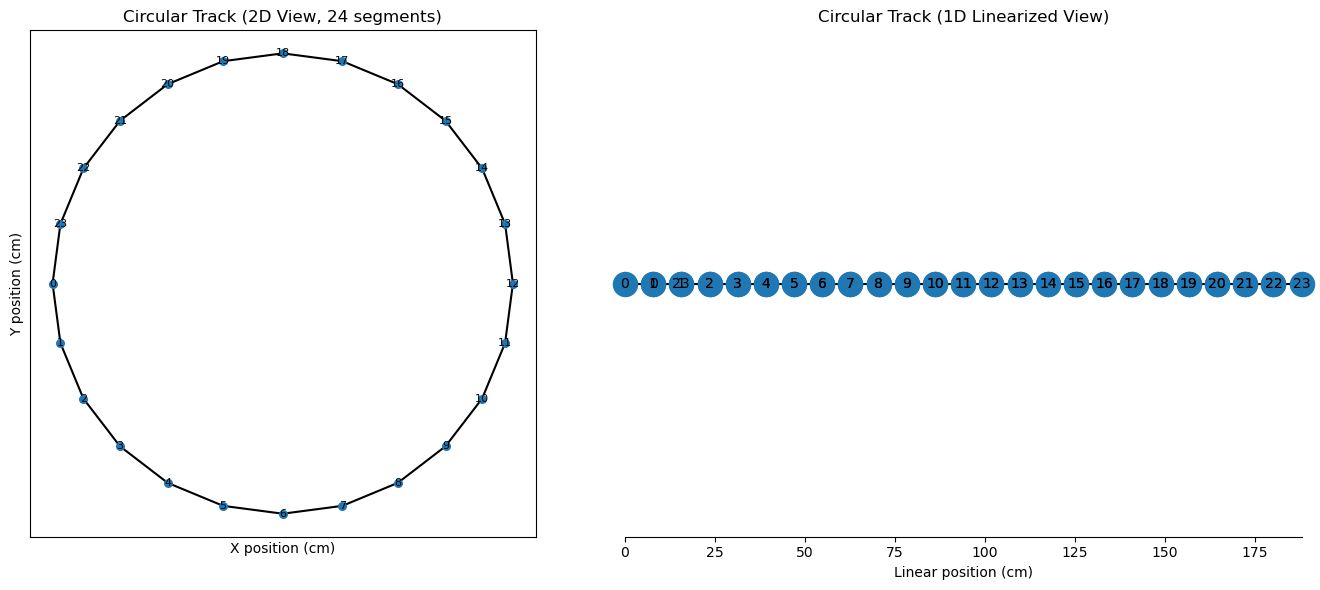

In [11]:
# Visualize the circular track
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 2D view
plot_track_graph(circle_track, ax=axes[0], node_size=30)
axes[0].set_title(f"Circular Track (2D View, {n_segments} segments)")
axes[0].set_xlabel("X position (cm)")
axes[0].set_ylabel("Y position (cm)")
axes[0].set_aspect('equal')

# 1D linearized view (no spacing between segments)
plot_graph_as_1D(circle_track, ax=axes[1], edge_spacing=0)
axes[1].set_title("Circular Track (1D Linearized View)")
axes[1].set_xlabel("Linear position (cm)")

plt.tight_layout()
plt.show()

In [12]:
# Simulate an animal running around the circle
# Generate positions at various angles
test_angles = np.array([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4])
position = np.array([
    [radius * np.cos(angle), radius * np.sin(angle)]
    for angle in test_angles
])

result = get_linearized_position(
    position,
    circle_track,
    edge_spacing=0  # No gaps between segments
)

print("\n📊 Linearization Results for Circular Track:")
print("=" * 80)
print(result.to_string(index=False))
print("\n💡 Linear position represents distance traveled around the circle")
print(f"   Full lap = {2 * np.pi * radius:.1f} cm")


📊 Linearization Results for Circular Track:
 linear_position  track_segment_id  projected_x_position  projected_y_position
      101.810430                12          3.000000e+01          0.000000e+00
      125.305145                16          2.121320e+01          2.121320e+01
      148.799859                19          1.836970e-15          3.000000e+01
      172.294574                21         -2.121320e+01          2.121320e+01
        7.831572                 1         -3.000000e+01          3.548754e-15
       31.326286                 3         -2.121320e+01         -2.121320e+01

💡 Linear position represents distance traveled around the circle
   Full lap = 188.5 cm


---
## Example 4: Complex W-Track

W-tracks are used in many spatial memory experiments. This example shows how to handle branching paths.

### Concept
The W-track has multiple branches. We need to specify the `edge_order` to control how the 2D structure maps to the 1D representation.

In [13]:
# Define a W-shaped track
# Visual layout:
#
#  3 -------- 2
#  |          |
#  |    4     |
#  |    |     |
#  0----5-----1
#
node_positions = [
    (0, 0),    # Node 0: bottom-left
    (30, 0),   # Node 1: bottom-right
    (30, 30),  # Node 2: top-right
    (0, 30),   # Node 3: top-left
    (15, 30),  # Node 4: top-center
    (15, 0),   # Node 5: bottom-center (junction)
]

edges = [
    (0, 5),  # Bottom-left to center
    (5, 1),  # Center to bottom-right
    (1, 2),  # Right vertical
    (0, 3),  # Left vertical
    (4, 5),  # Center vertical
]

w_track = make_track_graph(node_positions, edges)

print(f"W-track created with {w_track.number_of_nodes()} nodes and {w_track.number_of_edges()} edges")

W-track created with 6 nodes and 5 edges


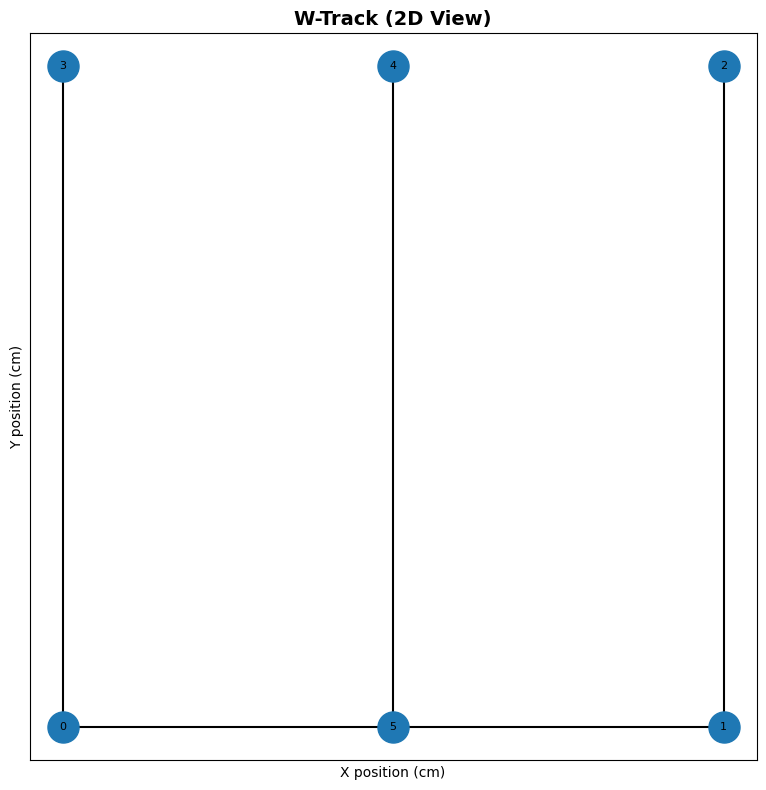


Edge information:
  Edge 0: nodes 0→5, length=15.0 cm
  Edge 1: nodes 0→3, length=30.0 cm
  Edge 2: nodes 1→5, length=15.0 cm
  Edge 3: nodes 1→2, length=30.0 cm
  Edge 4: nodes 4→5, length=30.0 cm


In [14]:
# Visualize the W-track structure
fig, ax = plt.subplots(figsize=(8, 8))
plot_track_graph(w_track, ax=ax, node_size=500)
ax.set_title("W-Track (2D View)", fontsize=14, fontweight='bold')
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print("\nEdge information:")
for i, edge in enumerate(w_track.edges()):
    dist = w_track.edges[edge]['distance']
    edge_id = w_track.edges[edge]['edge_id']
    print(f"  Edge {edge_id}: nodes {edge[0]}→{edge[1]}, length={dist:.1f} cm")

### Specifying Edge Order

For branching tracks, we specify the order in which edges appear in the linearized representation. This defines a "canonical path" through the track.

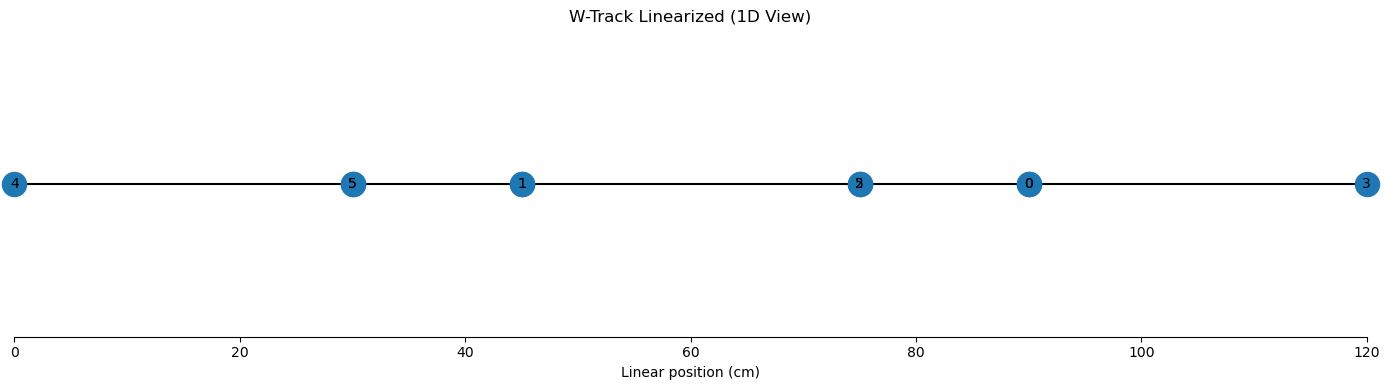

In [15]:
# Define the order: traverse one path through the W
# Path: center-top → center-bottom → bottom-right → right-vertical → bottom-left → left-vertical
edge_order = [
    (4, 5),  # Center vertical (top to bottom)
    (5, 1),  # Center to right
    (1, 2),  # Right vertical
    (5, 0),  # Center to left
    (0, 3),  # Left vertical
]

# Visualize the linearized representation
fig, ax = plt.subplots(figsize=(14, 4))
plot_graph_as_1D(w_track, edge_order=edge_order, ax=ax)
ax.set_title("W-Track Linearized (1D View)")
ax.set_xlabel("Linear position (cm)")
plt.tight_layout()
plt.show()

In [16]:
# Simulate positions on different arms of the W
position = np.array([
    [15, 20],  # On center vertical arm
    [20, 0],   # On bottom horizontal (between center and right)
    [30, 15],  # On right vertical arm
    [5, 0],    # On left horizontal (between left and center)
    [0, 15],   # On left vertical arm
])

result = get_linearized_position(
    position,
    w_track,
    edge_order=edge_order
)

print("\n📊 Linearization Results for W-Track:")
print("=" * 80)
print(result.to_string(index=False))
print("\n💡 Each position is assigned to the nearest track segment")
print("   Linear position follows the specified edge_order")


📊 Linearization Results for W-Track:
 linear_position  track_segment_id  projected_x_position  projected_y_position
            10.0                 4                  15.0                  20.0
            35.0                 2                  20.0                   0.0
            60.0                 3                  30.0                  15.0
            85.0                 0                   5.0                   0.0
           105.0                 1                   0.0                  15.0

💡 Each position is assigned to the nearest track segment
   Linear position follows the specified edge_order


---
## Example 5: Edge Mapping - Merging Track Segments

Sometimes you want to treat different spatial paths as behaviorally equivalent. The `edge_map` parameter lets you merge multiple edges into a single linear segment.

### Use Case: T-Maze
In a T-maze experiment, you might want left and right choice arms to have the same linear coordinates, since they represent the same behavioral decision point.

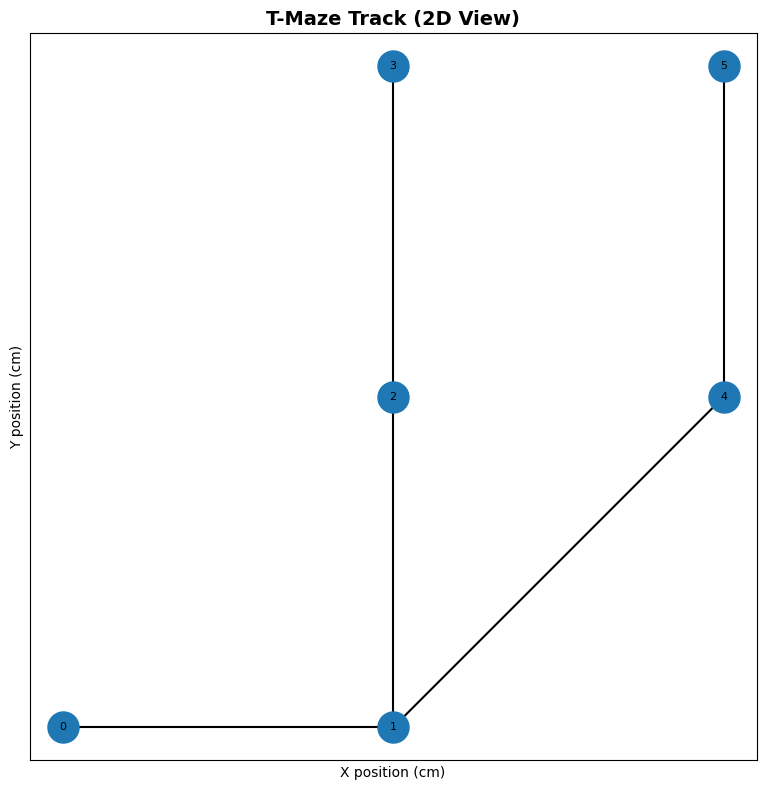

In [17]:
# Create a T-maze structure
# Layout:
#     3        5
#     |        |
#     2        4
#     |        |
# 0---1--------+
#
node_positions = [
    (0, 0),    # Node 0: start
    (15, 0),   # Node 1: stem/junction
    (15, 15),  # Node 2: left arm bottom
    (15, 30),  # Node 3: left arm end
    (30, 15),  # Node 4: right arm bottom
    (30, 30),  # Node 5: right arm end
]

edges = [
    (0, 1),  # Stem (edge_id 0)
    (1, 2),  # Left arm bottom (edge_id 1)
    (2, 3),  # Left arm top (edge_id 2)
    (1, 4),  # Right arm bottom (edge_id 3)
    (4, 5),  # Right arm top (edge_id 4)
]

tmaze_track = make_track_graph(node_positions, edges)

# Visualize
fig, ax = plt.subplots(figsize=(8, 8))
plot_track_graph(tmaze_track, ax=ax, node_size=500)
ax.set_title("T-Maze Track (2D View)", fontsize=14, fontweight='bold')
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [18]:
# Standard linearization (without edge mapping)
# Note: Using positions that are clearly on vertical segments
position = np.array([
    [15, 7],   # 7 cm up left arm (on vertical segment 1→2)
    [30, 22],  # 7 cm up right arm (on vertical segment 4→5)
    [15, 22],  # 22 cm up left arm
    [30, 27],  # 12 cm up right arm
])

result_no_mapping = get_linearized_position(
    position,
    tmaze_track,
    edge_order=[(0, 1), (1, 2), (2, 3), (1, 4), (4, 5)]
)

print("\n📊 Standard Linearization (Left and Right Arms Separate):")
print("=" * 80)
print(result_no_mapping.to_string(index=False))
print("\n⚠️  Notice: Positions on different arms have DIFFERENT linear_position")


📊 Standard Linearization (Left and Right Arms Separate):
 linear_position  track_segment_id  projected_x_position  projected_y_position
       22.000000                 1                  15.0                   7.0
       73.213203                 4                  30.0                  22.0
       37.000000                 3                  15.0                  22.0
       78.213203                 4                  30.0                  27.0

⚠️  Notice: Positions on different arms have DIFFERENT linear_position


In [19]:
# Now use edge_map to merge left and right arms
# Map edges to new segment IDs:
edge_map = {
    0: 'stem',          # Stem stays as 'stem'
    1: 'choice_bottom', # Left arm bottom → 'choice_bottom'
    2: 'choice_top',    # Left arm top → 'choice_top'
    3: 'choice_bottom', # Right arm bottom → 'choice_bottom' (MERGED!)
    4: 'choice_top',    # Right arm top → 'choice_top' (MERGED!)
}

result_with_mapping = get_linearized_position(
    position,
    tmaze_track,
    edge_order=[(0, 1), (1, 2), (2, 3), (1, 4), (4, 5)],
    edge_map=edge_map
)

print("\n📊 With Edge Mapping (Left and Right Arms Merged):")
print("=" * 80)
print(result_with_mapping.to_string(index=False))
print("\n✓ Now: Positions at same distance up left/right arms map to the same segments!")
print("  Positions 0 and 1: both 7cm up their arms → same 'choice_bottom' segment")
print("  Positions 2 and 3: higher up their arms → same 'choice_top' segment")
print("  This treats the two arms as behaviorally equivalent choice points.")


📊 With Edge Mapping (Left and Right Arms Merged):
 linear_position track_segment_id  projected_x_position  projected_y_position
            22.0    choice_bottom                  15.0                   7.0
            37.0       choice_top                  30.0                  22.0
            22.0    choice_bottom                  15.0                  22.0
            42.0       choice_top                  30.0                  27.0

✓ Now: Positions at same distance up left/right arms map to the same segments!
  Positions 0 and 1: both 7cm up their arms → same 'choice_bottom' segment
  Positions 2 and 3: higher up their arms → same 'choice_top' segment
  This treats the two arms as behaviorally equivalent choice points.


### Why Edge Mapping Matters

Edge mapping is powerful for behavioral analysis:

1. **Simplified analysis**: Treat multiple spatial paths as one behavioral state
2. **Place field analysis**: Identify neurons that encode "choice arm" regardless of left/right
3. **Trajectory decoding**: Analyze decision-making without spatial bias
4. **Semantic labels**: Use meaningful names instead of arbitrary edge IDs

**Key insight**: Positions that are the same distance from the start of merged edges get the **same** linear position, even though they're at different 2D locations.

---
## Example 6: Handling Noisy Data with HMM

Real tracking data often contains noise. The HMM (Hidden Markov Model) mode uses temporal continuity to make robust segment classifications.

### Concept
Instead of classifying each position independently, the HMM considers:
1. How far is the position from each track segment?
2. What segment was the animal on previously?
3. How easy is it to transition between segments?

In [20]:
# Use the L-track from earlier
# Add noise to simulate realistic tracking errors
true_position = np.array([
    [10, 0],
    [20, 0],
    [30, 0],
    [40, 0],
    [50, 5],   # Around the corner
    [50, 15],
    [50, 25],
    [50, 35],
    [50, 45],
])

# Add realistic tracking noise (e.g., from video tracking)
noise_level = 5.0  # 5 cm standard deviation
noisy_position = true_position + np.random.randn(*true_position.shape) * noise_level

print(f"Generated {len(noisy_position)} positions with {noise_level} cm noise")

Generated 9 positions with 5.0 cm noise


In [21]:
# Compare non-HMM vs HMM approaches
result_no_hmm = get_linearized_position(
    noisy_position,
    l_track,
    use_HMM=False  # Independent classification
)

result_with_hmm = get_linearized_position(
    noisy_position,
    l_track,
    use_HMM=True,
    sensor_std_dev=noise_level,  # Tell HMM about expected noise
    diagonal_bias=0.5  # Preference to stay on same segment
)

print("\n📊 Comparison: Non-HMM vs HMM Classification")
print("=" * 80)
print("\nWithout HMM (independent classification):")
print(result_no_hmm[['linear_position', 'track_segment_id']].to_string(index=True))

print("\nWith HMM (temporal continuity):")
print(result_with_hmm[['linear_position', 'track_segment_id']].to_string(index=True))

# Count segment switches
switches_no_hmm = np.sum(np.diff(result_no_hmm['track_segment_id']) != 0)
switches_with_hmm = np.sum(np.diff(result_with_hmm['track_segment_id']) != 0)

print(f"\n💡 Segment switches: {switches_no_hmm} (no HMM) vs {switches_with_hmm} (with HMM)")
print("   HMM produces smoother trajectories by using temporal information")


📊 Comparison: Non-HMM vs HMM Classification

Without HMM (independent classification):
   linear_position  track_segment_id
0        12.483571                 0
1        23.238443                 0
2        28.829233                 0
3        53.837174                 1
4        57.712800                 1
5        62.671351                 1
6        65.433599                 1
7        82.188562                 1
8        96.571237                 1

With HMM (temporal continuity):
   linear_position  track_segment_id
0        12.483571               0.0
1        23.238443               0.0
2        28.829233               0.0
3        47.896064               0.0
4        57.712800               1.0
5        62.671351               1.0
6        65.433599               1.0
7        82.188562               1.0
8        96.571237               1.0

💡 Segment switches: 1 (no HMM) vs 1 (with HMM)
   HMM produces smoother trajectories by using temporal information


### When to Use HMM

Use `use_HMM=True` when:
- Your position data has noise (e.g., from video tracking, GPS)
- Positions near track junctions might be ambiguous
- You want temporally consistent segment classification
- You have continuous trajectories (not random samples)

**Key parameters:**
- `sensor_std_dev`: Expected position noise (same units as your data)
- `diagonal_bias`: Higher values = more reluctance to switch segments (0-1 range)

---
## Summary

You've learned how to:

✅ Create track graphs from node positions and edges  
✅ Linearize 2D positions onto simple and complex tracks  
✅ Control the linearization with `edge_order` and `edge_spacing`  
✅ Merge track segments using `edge_map` for behavioral analysis  
✅ Handle noisy data with HMM-based classification  

### Next Steps

1. **Try with your own data**: Replace the example positions with your tracking data
2. **Experiment with parameters**: Adjust `edge_spacing`, `sensor_std_dev`, and `diagonal_bias`
3. **Explore the API**: Check function docstrings for more options
4. **Visualize results**: Use `plot_track_graph()` and `plot_graph_as_1D()` to inspect your data

### Common Issues & Solutions

**Problem**: Positions far from track  
→ *Solution*: Check that position units match track units (both in cm, both in pixels, etc.)

**Problem**: Unexpected segment assignments  
→ *Solution*: Visualize your track with `plot_track_graph()` to verify structure

**Problem**: Jumpy segment classifications  
→ *Solution*: Use `use_HMM=True` with appropriate `sensor_std_dev`

**Problem**: Edge order confusion  
→ *Solution*: Use `infer_edge_layout()` for automatic ordering, or specify manually

### Resources

- **Documentation**: See function docstrings (`help(get_linearized_position)`)
- **GitHub**: [github.com/LorenFrankLab/track_linearization](https://github.com/LorenFrankLab/track_linearization)
- **Issues**: Report bugs or ask questions on GitHub Issues